<a href="https://colab.research.google.com/github/filipp134/vk_bot_detection/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install eli5
!pip install shap
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing
import joblib
import eli5
from eli5.sklearn import PermutationImportance
import shap
import json
%matplotlib inline

     |████████████████████████████████| 564 kB 13.3 MB/s 


In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/filipp134/vk_bot_detection/main/Dataset_for_VK_project.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)

# Exploring data

In [ ]:
df.head()

,uid,has_photo,sex,has_mobile,followers_count,contacts,relatives,relation,personal,activities,music,movies,tv,books,about,quotes,albums,audios,followers,friends,pages,photos,subscriptions,videos,clips_followers,age,city,country,avg_cl,trans,deg_centr,average_neighbor_degree,average_degree_connectivity,k_nearest_neighbors,degree_centrality,closeness_centrality,betweenness_centrality,diameter,average_shortest_path_length,target
0,648249344,0,2,1.0,0.0,0,1,1,1,1,1,1,1,1,1,1,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,21.0,0.0,0.0,0.000000,0.000000,1.000000,6.482493e+08,0.000000,0.000000,1.000000,0.000000,0.000000,0,0,0
1,645333001,1,2,1.0,2.0,0,0,0,0,0,0,0,0,0,0,0,0.0,58.0,2.0,14.0,17.0,3.0,0.0,0.0,16.0,26.0,0.0,0.0,0.719048,0.354167,0.257143,2.612393e+08,7.508862,7.508862,0.257143,0.588401,0.057143,2,1,0
2,651165709,1,2,1.0,9.0,0,1,1,1,1,1,1,1,1,1,1,0.0,15.0,9.0,130.0,1086.0,3.0,15.0,2.0,139.0,40.0,154.0,1.0,0.445322,0.095878,0.038501,4.023961e+08,34.912425,34.912425,0.038501,0.511661,0.006917,2,1,0
3,649232401,1,1,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,9.0,89.0,0.0,0.0,0.0,0.0,24.0,0.0,1.0,0.000000,0.000000,1.000000,6.492324e+08,0.000000,0.000000,1.000000,0.000000,0.000000,0,0,0
4,639664147,0,1,1.0,1.0,0,1,1,1,1,1,1,1,1,1,1,0.0,0.0,1.0,24.0,34.0,0.0,0.0,0.0,25.0,59.0,0.0,0.0,0.726571,0.446131,0.260000,3.456780e+08,10.625207,10.625207,0.260000,0.584422,0.032174,2,1,0


In [ ]:
df.shape

(11766, 40)

In [ ]:
df.columns

Index(['uid', 'has_photo', 'sex', 'has_mobile', 'followers_count', 'contacts',
       'relatives', 'relation', 'personal', 'activities', 'music', 'movies',
       'tv', 'books', 'about', 'quotes', 'albums', 'audios', 'followers',
       'friends', 'pages', 'photos', 'subscriptions', 'videos',
       'clips_followers', 'age', 'city', 'country', 'avg_cl', 'trans',
       'deg_centr', 'average_neighbor_degree', 'average_degree_connectivity',
       'k_nearest_neighbors', 'degree_centrality', 'closeness_centrality',
       'betweenness_centrality', 'diameter', 'average_shortest_path_length',
       'target'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11766 entries, 0 to 11765
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   uid                           11766 non-null  int64  
 1   has_photo                     11766 non-null  int64  
 2   sex                           11766 non-null  int64  
 3   has_mobile                    11766 non-null  float64
 4   followers_count               11766 non-null  float64
 5   contacts                      11766 non-null  int64  
 6   relatives                     11766 non-null  int64  
 7   relation                      11766 non-null  int64  
 8   personal                      11766 non-null  int64  
 9   activities                    11766 non-null  int64  
 10  music                         11766 non-null  int64  
 11  movies                        11766 non-null  int64  
 12  tv                            11766 non-null  int64  
 13  b

In [ ]:
df['contacts'].value_counts()

0    11766
Name: contacts, dtype: int64

In [ ]:
df.drop('contacts', axis=1, inplace=True)

In [ ]:
df['subscriptions'].value_counts()

0.0      8159
1.0       805
2.0       387
3.0       285
4.0       209
         ... 
217.0       1
239.0       1
212.0       1
223.0       1
863.0       1
Name: subscriptions, Length: 214, dtype: int64

In [ ]:
df[(df.friends > 0) & (df.friends < 500)].friends.describe()

count    6555.000000
mean       56.147826
std        76.464044
min         1.000000
25%         5.000000
50%        23.000000
75%        76.000000
max       499.000000
Name: friends, dtype: float64

In [ ]:
df[df.friends > 0].friends.quantile(0.75)

84.0

In [ ]:
df['target'].value_counts()

0    9969
1    1797
Name: target, dtype: int64

In [ ]:
df[df.uid.isin(df[df.friends > 0].uid)]['target'].value_counts()

0    5180
1    1565
Name: target, dtype: int64

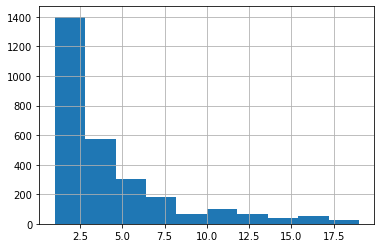

In [ ]:
df[(df.followers_count < 20) & (df.followers_count >0)]['followers_count'].hist()

In [ ]:
df['city'].value_counts()

0.0          8141
1.0          1164
2.0           337
49.0          116
99.0          109
             ... 
1710959.0       1
2367.0          1
1463.0          1
9620.0          1
2625.0          1
Name: city, Length: 623, dtype: int64

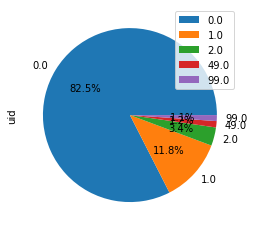

In [ ]:
data_with_cities = df.groupby('city').count()
data_with_cities[data_with_cities['uid'] > 100].plot.pie(autopct="%.1f%%", y='uid')

In [ ]:
df['sex'].value_counts()

1    6755
2    4960
0      51
Name: sex, dtype: int64

In [ ]:
df[df['sex']==0]['target'].value_counts()

0    50
1     1
Name: target, dtype: int64

In [ ]:
df[df['sex']==1]['target'].value_counts()

0    5747
1    1008
Name: target, dtype: int64

In [ ]:
df[df['sex']==2]['target'].value_counts()

0    4172
1     788
Name: target, dtype: int64

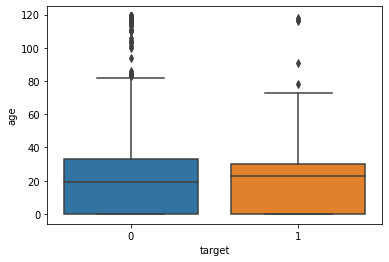

In [ ]:
sns.boxplot(data=df, x='target', y='age')

In [ ]:
df[df.target == 0].personal.mean()

0.5315477981743405

In [ ]:
df[df.target == 1].personal.mean()

0.3110740122426266

In [ ]:
df[df.target == 0].has_photo.mean()

0.5762864881131508

In [ ]:
df[df.target == 1].has_photo.mean()

0.9682804674457429

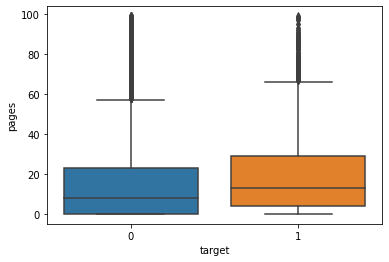

In [ ]:
sns.boxplot(data=df[df['pages'] < 100], x='target', y='pages')

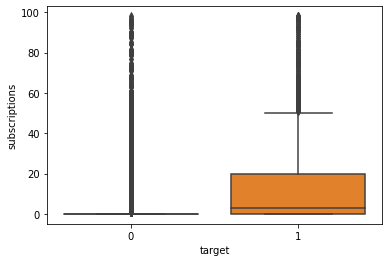

In [ ]:
sns.boxplot(data=df[df['subscriptions'] < 100], x='target', y='subscriptions')

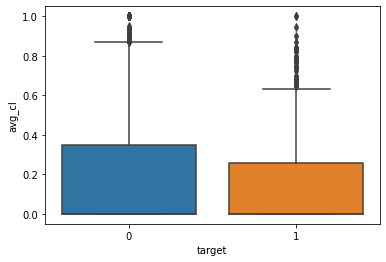

In [ ]:
sns.boxplot(data=df, x='target', y='avg_cl')

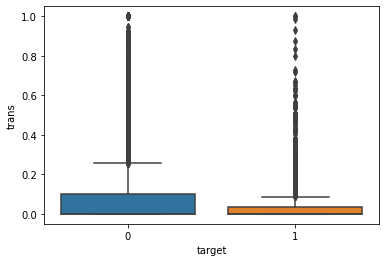

In [ ]:
sns.boxplot(data=df, x='target', y='trans')

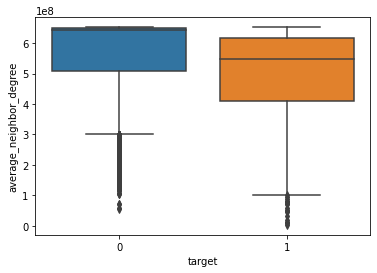

In [ ]:
sns.boxplot(data=df, x='target', y='average_neighbor_degree')

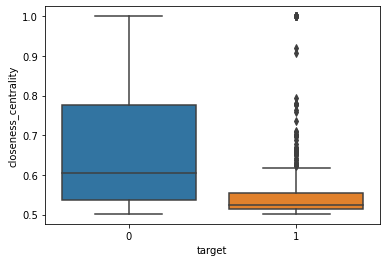

In [ ]:
sns.boxplot(data=df[df['closeness_centrality'] > 0], x='target', y='closeness_centrality')

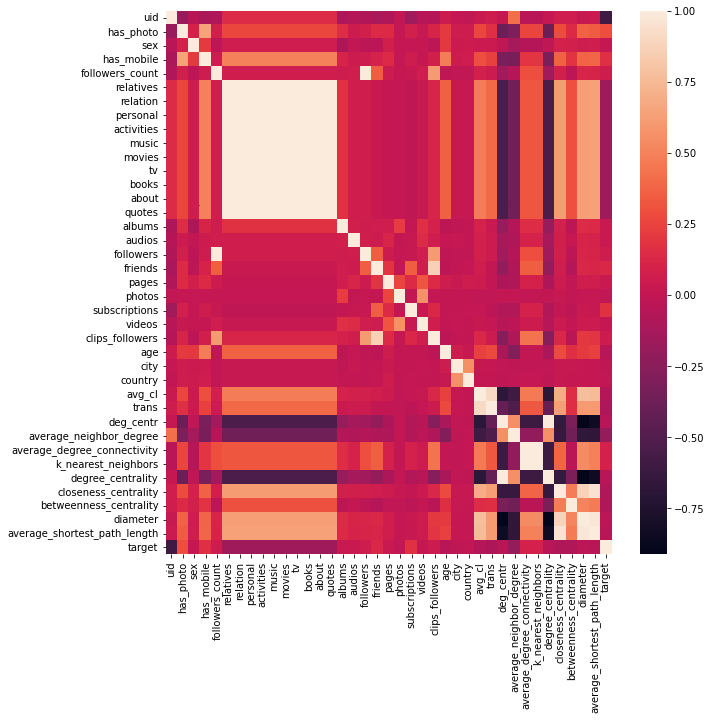

In [ ]:
corr = df.corr()
fig, ax = plt.subplots(figsize=(10,10))         
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, ax=ax)

In [ ]:
corr

,uid,has_photo,sex,has_mobile,followers_count,relatives,relation,personal,activities,music,movies,tv,books,about,quotes,albums,audios,followers,friends,pages,photos,subscriptions,videos,clips_followers,age,city,country,avg_cl,trans,deg_centr,average_neighbor_degree,average_degree_connectivity,k_nearest_neighbors,degree_centrality,closeness_centrality,betweenness_centrality,diameter,average_shortest_path_length,target
uid,1.000000,-0.182193,-0.042038,-0.100482,-0.084965,0.145527,0.145527,0.145527,0.145527,0.145527,0.145527,0.145527,0.145527,0.145527,0.145527,-0.096894,-0.067229,-0.084965,-0.113498,-0.076749,-0.001169,-0.144857,-0.051357,-0.053997,0.046440,0.008097,-0.007374,0.034929,0.057018,0.020116,0.424484,-0.044502,-0.044502,0.020116,0.060585,0.059767,0.026345,0.036978,-0.596500
has_photo,-0.182193,1.000000,0.094739,0.645549,0.076748,0.261951,0.261951,0.261951,0.261951,0.261951,0.261951,0.261951,0.261951,0.261951,0.261951,0.153622,0.051156,0.076748,0.137733,0.139714,0.010472,0.088297,0.026944,0.108410,0.208576,0.051775,0.055593,0.265551,0.170724,-0.384667,-0.302781,0.258880,0.258880,-0.384667,0.284190,0.136714,0.368414,0.349417,0.293097
sex,-0.042038,0.094739,1.000000,0.210162,-0.028334,0.059933,0.059933,0.059933,0.059933,0.059933,0.059933,0.059933,0.059933,0.059933,0.059933,-0.096003,0.001359,-0.028334,-0.026208,0.080767,0.009643,0.013568,0.019543,-0.026076,0.202896,0.039846,0.045993,0.036533,0.041875,-0.014991,-0.127934,-0.064448,-0.064448,-0.014991,0.092469,0.086492,0.056460,0.071573,0.017542
has_mobile,-0.100482,0.645549,0.210162,1.000000,0.053349,0.493540,0.493540,0.493540,0.493540,0.493540,0.493540,0.493540,0.493540,0.493540,0.493540,0.105671,0.050688,0.053349,0.098295,0.137255,0.007285,0.057874,0.021269,0.078619,0.480012,0.050796,0.059751,0.295993,0.243269,-0.320450,-0.327498,0.190929,0.190929,-0.320450,0.366207,0.180073,0.373837,0.383259,0.165748
followers_count,-0.084965,0.076748,-0.028334,0.053349,1.000000,0.068794,0.068794,0.068794,0.068794,0.068794,0.068794,0.068794,0.068794,0.068794,0.068794,0.054678,0.067595,1.000000,0.355349,0.045425,0.017189,0.024471,0.061331,0.605825,-0.015881,-0.005614,-0.002440,0.086651,0.048707,-0.145493,-0.053600,0.291550,0.291550,-0.145493,0.079896,-0.019278,0.118164,0.110844,0.058470
relatives,0.145527,0.261951,0.059933,0.493540,0.068794,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.174856,0.071476,0.068794,0.036255,0.016670,0.012541,-0.012271,0.028138,0.113578,0.360858,0.021910,0.025054,0.483452,0.397628,-0.529256,-0.361336,0.321946,0.321946,-0.529256,0.614529,0.300598,0.621527,0.639679,-0.158621
relation,0.145527,0.261951,0.059933,0.493540,0.068794,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.174856,0.071476,0.068794,0.036255,0.016670,0.012541,-0.012271,0.028138,0.113578,0.360858,0.021910,0.025054,0.483452,0.397628,-0.529256,-0.361336,0.321946,0.321946,-0.529256,0.614529,0.300598,0.621527,0.639679,-0.158621
personal,0.145527,0.261951,0.059933,0.493540,0.068794,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.174856,0.071476,0.068794,0.036255,0.016670,0.012541,-0.012271,0.028138,0.113578,0.360858,0.021910,0.025054,0.483452,0.397628,-0.529256,-0.361336,0.321946,0.321946,-0.529256,0.614529,0.300598,0.621527,0.639679,-0.158621
activities,0.145527,0.261951,0.059933,0.493540,0.068794,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.174856,0.071476,0.068794,0.036255,0.016670,0.012541,-0.012271,0.028138,0.113578,0.360858,0.021910,0.025054,0.483452,0.397628,-0.529256,-0.361336,0.321946,0.321946,-0.529256,0.614529,0.300598,0.621527,0.639679,-0.158621
music,0.145527,0.261951,0.059933,0.493540,0.068794,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.174856,0.071476,0.068794,0.036255,0.016670,0.012541,-0.012271,0.028138,0.113578,0.360858,0.021910,0.025054,0.483452,0.397628,-0.

In [ ]:
df[['relation', 'personal', 'activities', 'music', 'movies', 'tv', 'books', 'about', 'quotes']].head(10)

,relation,personal,activities,music,movies,tv,books,about,quotes
0,1,1,1,1,1,1,1,1,1
1,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,1,1,1,1
3,0,0,0,0,0,0,0,0,0
4,1,1,1,1,1,1,1,1,1
5,1,1,1,1,1,1,1,1,1
6,1,1,1,1,1,1,1,1,1
7,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0


In [ ]:
df.drop(['relatives', 'personal', 'activities', 'music', 'movies', 'tv', 'books', 'about', 'quotes'], axis=1, inplace=True)

In [ ]:
df.drop('followers_count', axis=1, inplace=True)

In [ ]:
df.drop('k_nearest_neighbors', axis=1, inplace=True)

In [ ]:
df.drop('deg_centr', axis=1, inplace=True)

In [ ]:
df.drop('average_shortest_path_length', axis=1, inplace=True)

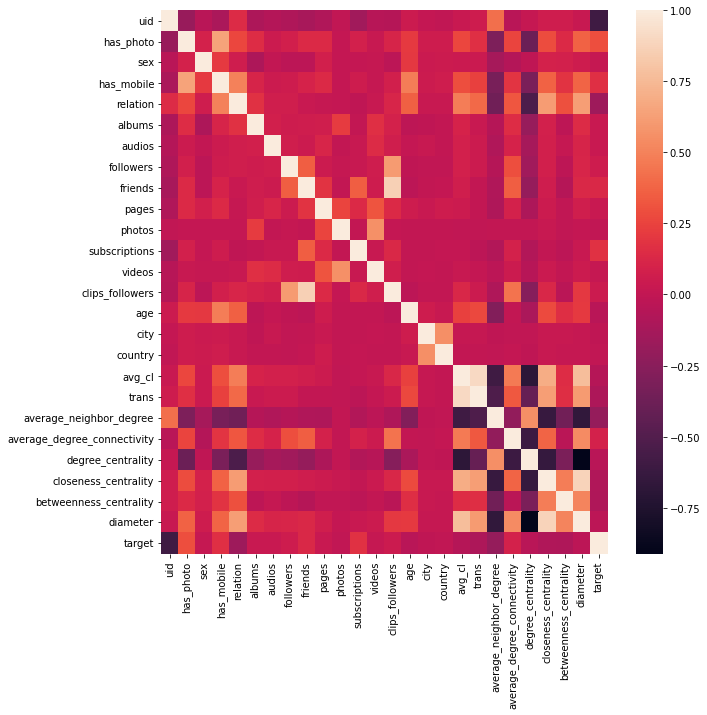

In [ ]:
corr = df.corr()
fig, ax = plt.subplots(figsize=(10,10))         
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, ax=ax)

In [ ]:
df.drop('uid', axis=1, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11766 entries, 0 to 11765
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   has_photo                    11766 non-null  int64  
 1   sex                          11766 non-null  int64  
 2   has_mobile                   11766 non-null  float64
 3   relation                     11766 non-null  int64  
 4   albums                       11766 non-null  float64
 5   audios                       11766 non-null  float64
 6   followers                    11766 non-null  float64
 7   friends                      11766 non-null  float64
 8   pages                        11766 non-null  float64
 9   photos                       11766 non-null  float64
 10  subscriptions                11766 non-null  float64
 11  videos                       11766 non-null  float64
 12  clips_followers              11766 non-null  float64
 13  age             

In [ ]:
df.shape

(11766, 25)

# Models

In [ ]:
X = df.drop('target', axis=1)
y = df['target']
X_log = df.drop('target', axis=1)
y_log = df['target']
X_log = preprocessing.StandardScaler().fit(X).transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)
X_trai, X_tes, y_trai, y_tes = train_test_split(X_log, y_log, test_size=0.2, random_state=50)

In [ ]:
y.value_counts()

0    9969
1    1797
Name: target, dtype: int64

In [ ]:
y_train.value_counts()

0    7976
1    1436
Name: target, dtype: int64

In [ ]:
1436 / 1797

0.7991096271563717

In [ ]:
1797 / 9969

0.18025880228709

In [ ]:
1436 / 7976

0.18004012036108324

## Logistic Regression

In [ ]:
parameters_1 = {'solver':('liblinear', 'lbfgs'), 'C':[0.5, 1, 10, 100], 'random_state':[0, 1], 'max_iter':[1000, 10000]}
model_1 = LogisticRegression()
clf_1 = GridSearchCV(model_1, parameters_1)
clf_1.fit(X_trai, y_trai)

GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.5, 1, 10, 100], 'max_iter': [1000, 10000],
                         'random_state': [0, 1],
                         'solver': ('liblinear', 'lbfgs')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
model_1 = LogisticRegression(solver='lbfgs', C=1.0, max_iter=10000).fit(X_trai, y_trai)

In [ ]:
predictions_1 = model_1.predict_proba(X_tes)[:,1]
roc_auc_score(y_tes, predictions_1)

0.8758063193476336

In [ ]:
perm = PermutationImportance(model_1, random_state=1).fit(X_trai, y_trai)
eli5.show_weights(perm, feature_names = df.drop('target', axis=1).columns.to_list())

Weight,Feature
0.0701 ± 0.0053,average_neighbor_degree
0.0289 ± 0.0017,closeness_centrality
0.0197 ± 0.0019,subscriptions
0.0178 ± 0.0013,relation
0.0166 ± 0.0012,trans
0.0150 ± 0.0008,has_photo
0.0121 ± 0.0013,clips_followers
0.0083 ± 0.0008,avg_cl
0.0081 ± 0.0018,betweenness_centrality
0.0066 ± 0.0026,average_degree_connectivity


## Random Forest Classification

In [ ]:
parameters_2 = {'max_depth':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'random_state':[0, 1]}
model_2 = RandomForestClassifier()
clf_2 = GridSearchCV(model_2, parameters_2)
clf_2.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              ra

In [ ]:
model_2 = RandomForestClassifier(max_depth=None, random_state=None).fit(X_train, y_train)

In [ ]:
predictions_2 = model_2.predict_proba(X_test)[:,1]
roc_auc_score(y_test, predictions_2)

0.9299065420560748

In [ ]:
perm = PermutationImportance(model_2, random_state=1).fit(X, y)
eli5.show_weights(perm, feature_names = df.drop('target', axis=1).columns.to_list())

Weight,Feature
0.2934 ± 0.0057,average_neighbor_degree
0.1405 ± 0.0037,has_photo
0.0774 ± 0.0022,pages
0.0093 ± 0.0008,subscriptions
0.0089 ± 0.0008,friends
0.0067 ± 0.0005,photos
0.0058 ± 0.0007,country
0.0054 ± 0.0006,followers
0.0049 ± 0.0004,age
0.0044 ± 0.0004,relation


In [ ]:
joblib.dump(model_2, 'model.pkl')

['model.pkl']

## Gradient Boosting Classification

In [ ]:
parameters_3 = {'n_estimators':[10, 100, 1000], 'learning_rate':[0.5, 1.0], 'max_depth':[0.1, 0.5, 1]}
model_3 = GradientBoostingClassifier()
clf_3 = GridSearchCV(model_3, parameters_3)
clf_3.fit(X_train, y_train)

GridSearchCV(estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.5, 1.0],
                         'max_depth': [0.1, 0.5, 1],
                         'n_estimators': [10, 100, 1000]})

In [ ]:
model_3 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3).fit(X_train, y_train)

In [ ]:
predictions_3 = model_3.predict_proba(X_test)[:,1]
roc_auc_score(y_test, predictions_3)

0.9749108027681372

In [ ]:
perm = PermutationImportance(model_3, random_state=1).fit(X, y)
eli5.show_weights(perm, feature_names = df.drop('target', axis=1).columns.to_list())

Weight,Feature
0.2850 ± 0.0055,average_neighbor_degree
0.1399 ± 0.0033,has_photo
0.1147 ± 0.0012,pages
0.0572 ± 0.0042,closeness_centrality
0.0157 ± 0.0012,friends
0.0078 ± 0.0013,subscriptions
0.0059 ± 0.0004,followers
0.0039 ± 0.0010,avg_cl
0.0031 ± 0.0004,photos
0.0028 ± 0.0012,relation


 94%|=================== | 11110/11766 [00:12<00:00]       

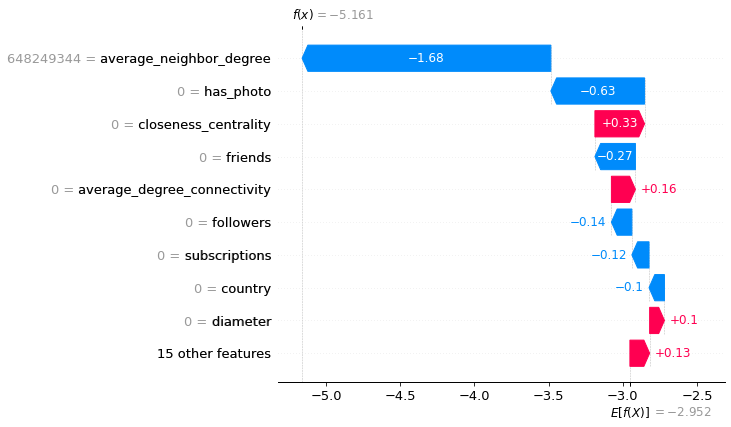

In [ ]:
explainer = shap.Explainer(model_3, X)
shap_values = explainer(X)
shap.plots.waterfall(shap_values[0])